In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

## Explicit Method

In [28]:
L = 1
t_max = 5

dx = .01
dt = .1

Nx = int(L/dx) + 1
Nt = int(t_max/.1)

x_grid = np.linspace(0,L,Nx)
t_grid = np.linspace(0,t_max,Nt)

U = []

u_t_x_0 = []

for x in x_grid:
    u_t_x_0.append(x*(x-1)*(x-3))
    U.append(u_t_x_0)

In [29]:
for i in range(Nt):
    u_t_x = []
    
    u_line = U[-1]
    
    for i in range(1,Nx-1):
        # Equation 5.14 (slightly modified) to calculate u at each x value:
        u = -u_line[i] * (dt/(2*dx)) * (u_line[i+1] - u_line[i-1]) + u_line[i]
        # Append this value to the time step line
        u_t_x.append(u)

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,0)
    u_t_x.insert(len(u_line),0)

    # Now append the full solutions matrix
    U.append(u_t_x) 

/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_58060/2080610295.py:8: RuntimeWarning: overflow encountered in scalar multiply
  u = -u_line[i] * (dt/(2*dx)) * (u_line[i+1] - u_line[i-1]) + u_line[i]
/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_58060/2080610295.py:8: RuntimeWarning: invalid value encountered in scalar add
  u = -u_line[i] * (dt/(2*dx)) * (u_line[i+1] - u_line[i-1]) + u_line[i]
/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_58060/2080610295.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  u = -u_line[i] * (dt/(2*dx)) * (u_line[i+1] - u_line[i-1]) + u_line[i]


In [30]:
pd.DataFrame(U)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.0,0.029601,0.058408,0.086427,0.113664,0.140125,0.165816,0.190743,0.214912,0.238329,...,0.171171,0.153088,0.134757,0.116184,0.097375,0.078336,0.059073,0.039592,0.019899,-0.0
1,0.0,0.029601,0.058408,0.086427,0.113664,0.140125,0.165816,0.190743,0.214912,0.238329,...,0.171171,0.153088,0.134757,0.116184,0.097375,0.078336,0.059073,0.039592,0.019899,-0.0
2,0.0,0.029601,0.058408,0.086427,0.113664,0.140125,0.165816,0.190743,0.214912,0.238329,...,0.171171,0.153088,0.134757,0.116184,0.097375,0.078336,0.059073,0.039592,0.019899,-0.0
3,0.0,0.029601,0.058408,0.086427,0.113664,0.140125,0.165816,0.190743,0.214912,0.238329,...,0.171171,0.153088,0.134757,0.116184,0.097375,0.078336,0.059073,0.039592,0.019899,-0.0
4,0.0,0.029601,0.058408,0.086427,0.113664,0.140125,0.165816,0.190743,0.214912,0.238329,...,0.171171,0.153088,0.134757,0.116184,0.097375,0.078336,0.059073,0.039592,0.019899,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,0.0,0.001913,0.003826,0.005739,0.007652,0.009565,0.011478,0.013391,0.015304,0.017217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
147,0.0,0.001876,0.003753,0.005629,0.007506,0.009382,0.011258,0.013135,0.015011,0.016887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
148,0.0,0.001841,0.003682,0.005524,0.007365,0.009206,0.011047,0.012888,0.014729,0.016570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
149,0.0,0.001807,0.003615,0.005422,0.007229,0.009037,0.010844,0.012651,0.014458,0.016265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


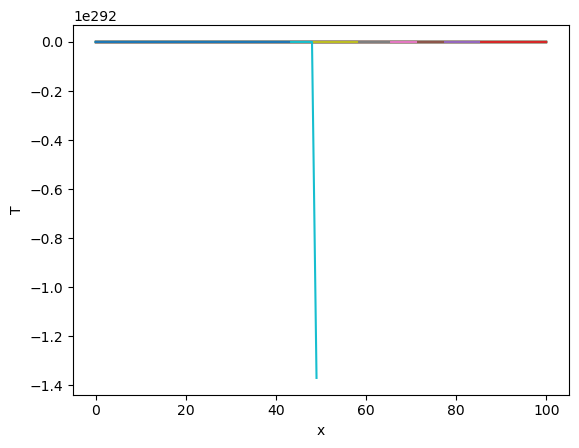

In [34]:
# Plotting t = 0 to t = 1000, in 20dt increments
for i in np.arange(0,len(U[:500]),5):
    plt.plot(U[i])
    plt.xlabel('x')
    plt.ylabel('T')
plt.show()

In [24]:
def heat_plotter(U, steps):

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('x')  # Set x-axis label
    ax.set_ylabel('T')  # Set y-axis label

    # Set the y-axis limits
    y_min = min([min(u) for u in U]) - 0.5  # Find the minimum y-value in U with some buffer
    y_max = max([max(u) for u in U]) + 0.5  # Find the maximum y-value in U with some buffer
    ax.set_ylim(y_min, y_max)

    lines = []  # List to store line objects
    alpha_decay = .5  # Factor to reduce the alpha of previous lines

    plt.show()

    for i in np.arange(0, len(U), len(U)//steps):
        # Update the alpha values of existing lines
        for line in lines:
            line.set_alpha(line.get_alpha() * alpha_decay)

        # Add new line
        new_line, = ax.plot(U[i], color='red', alpha=1.0)  # Start with full opacity
        lines.append(new_line)  # Store the new line object
        ax.set_title(f"Plot at time = {i/(len(U)-1)}s")  # Update the title with the current step

        # Handling plot display
        clear_output(wait=True)  # Clear the previous plot
        display(fig)  # Display the current figure

        time.sleep(0.25)  # Pause for half a second before the next update

ValueError: Axis limits cannot be NaN or Inf

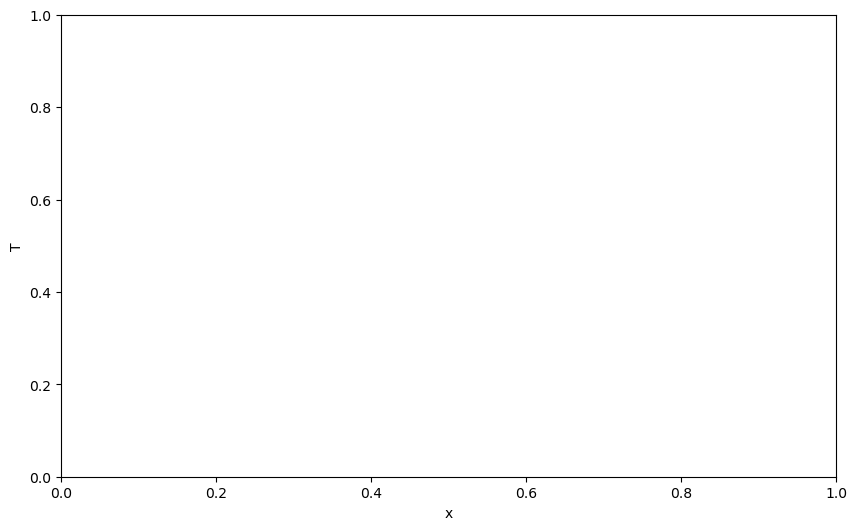

In [31]:
heat_plotter(U, 10)

In [6]:
# Boundary Condition Functions (Direchelet - time domain)

def u_t_0(t):
    '''
    Assigns the initial value for the 0-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float]    
    '''
    return 0

def u_t_L(t):
    '''
    Assigns the initial value for the L-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return 0

# Initial Condition Functions

def u_0_x(x):
    '''
    Assigns the initial values for u (non-boundary points).
    If the initial value is a constant, leave function as-is.
    If the initial value is a function of x, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return x * (x - 1) * (x - 3)

In [7]:
# Assign length
L = 3
t_max = 5

# Grid spacing
dx = .1
dt = .1 # !-Note: For explicit needs to be less than dt**2/(2*D), implicit has no such restrictions for stability

# Number of dx nodes, including 0 node
Nx = int(L/dx) + 1

# Discretize x and t
x = np.arange(0,L+dx,dx)
t = np.arange(0,t_max+dt,dt)

# Create return array (n x m matrix)
n = len(x)
m = len(t)
T = np.zeros((m,n))

# Set boundary values
T[:,0] = u_t_0(0)
T[:,-1] = u_t_L(0)

# Derive the Lambda, as lambo
lambo = dt/(2*dx)

In [8]:
# LHS = A: a tridiagnonal matrix
A = np.diag([1+2*lambo]*(Nx-2)) + np.diag([-lambo]*(Nx-3),1) + np.diag([-lambo]*(Nx-3),-1)

## Crank-Nicholson

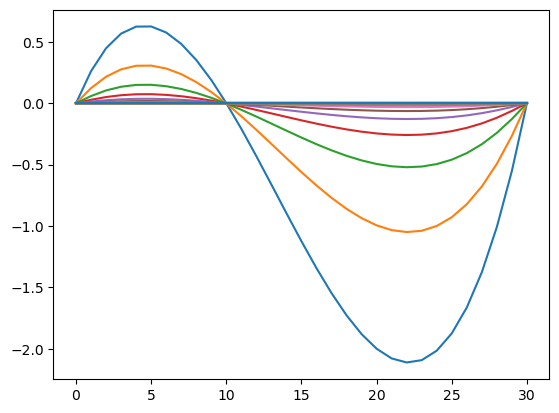

In [9]:
# Assign length
L = 3

# Grid spacing
dx = .1
dt = .1 # !-Note: For explicit needs to be less than dt**2/(2*D), implicit has no such restrictions for stability

# Number of dx nodes, including 0 node
Nx = int(L/dx) + 1

# Discretize x and t
x = np.arange(0,L+dx,dx)
t = np.arange(0,L+dt,dt)

# Create return array (n x m matrix)
n = len(x)
m = len(t)
Tcr = np.zeros((n,m))

# Set initial conditions
Tcr[0,:] = u_0_x(x)

# Set boundary values
Tcr[:,0] = u_t_0(0)
Tcr[:,-1] = u_t_L(0)

# Derive the Lambda
lambo = dt/(2*dx)

# LHS = A: a tridiagnonal matrix
A = np.diag([2+2*lambo]*(Nx-2)) + np.diag([-lambo]*(Nx-3),1) + np.diag([-lambo]*(Nx-3),-1)

# RHS tridagonal matrix
B = np.diag([2-2*lambo]*(Nx-2)) + np.diag([lambo]*(Nx-3),1) + np.diag([lambo]*(Nx-3),-1)

for i in range(0,n-1):
    b = Tcr[i,1:-1].copy() #Need the copy here!
    b[0] = b[0] + lambo*Tcr[i+1,0]
    b[-1] = b[-1] + lambo*Tcr[i+1,-1]
    sol = np.linalg.solve(A,b)
    Tcr[i+1,1:-1] = sol
Tcr

pd.DataFrame(Tcr).round(3)

for i in np.arange(0,len(Tcr)):
    plt.plot(Tcr[i])
plt.show()